In [60]:
# Installation of required packages
import os
import torch

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.1.0+cu121
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Cora dataset

In [61]:
def print_dataset(dataset):
  data = dataset[0]
  print('Name:', dataset)
  print('Number of graphs:', len(dataset))
  print('Nodes:', data.num_nodes)
  print('Edges:', data.num_edges // 2)
  print('Features:', dataset.num_features)
  print('Classes:', dataset.num_classes)
  print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
  print(f'Label rate: {data.train_mask.sum().item() / data.num_nodes:.4f}')

In [62]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures


dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
print_dataset(dataset)

Name: Cora()
Number of graphs: 1
Nodes: 2708
Edges: 5278
Features: 1433
Classes: 7
Average node degree: 3.90
Label rate: 0.0517


In [63]:
data = dataset[0]
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


## GCN

In [64]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, data, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(data, hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [65]:
def train(model,data,data_mask,optimizer,criterion):
  model.train()
  optimizer.zero_grad()
  out = model(data.x, data.edge_index)
  loss = criterion(out[data.train_mask], data.y[data.train_mask])
  pred = out.argmax(dim=1)
  correct = pred[data_mask] == data.y[data_mask]
  acc = int(correct.sum()) / int(data_mask.sum())
  loss.backward()
  optimizer.step()
  return acc,loss.item()

def eval(model,data,data_mask):
  model.eval()
  out = model(data.x, data.edge_index)
  pred = out.argmax(dim=1)
  correct = pred[data_mask] == data.y[data_mask]
  acc = int(correct.sum()) / int(data_mask.sum())
  loss = criterion(out[data_mask], data.y[data_mask])
  return acc,loss.item()

def model_training(n_epochs,model,data,optimizer,criterion):
  train_losses = []
  train_accs = []
  val_losses = []
  val_accs = []
  best_val_loss = 0.0

  for epoch in range(1,n_epochs+1):
    train_acc, train_loss = train(model,data,data.train_mask,optimizer,criterion)
    val_acc, val_loss = eval(model,data,data.val_mask)
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

  return train_losses, train_accs, val_losses, val_accs


In [66]:
import numpy as np
import matplotlib.pyplot as plt

def plot_results(n_epochs, train_losses, train_accs, val_losses, val_accs):
  N_EPOCHS = n_epochs
  # Plot results
  plt.figure(figsize=(20, 6))
  _ = plt.subplot(1,2,1)
  plt.plot(np.arange(N_EPOCHS)+1, train_losses, linewidth=3)
  plt.plot(np.arange(N_EPOCHS)+1, val_losses, linewidth=3)
  _ = plt.legend(['Train', 'Validation'])
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Loss')

  _ = plt.subplot(1,2,2)
  plt.plot(np.arange(N_EPOCHS)+1, train_accs, linewidth=3)
  plt.plot(np.arange(N_EPOCHS)+1, val_accs, linewidth=3)
  _ = plt.legend(['Train', 'Validation'])
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Accuracy')

In [77]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0]
data = data.to(device)
model = GCN(data,hidden_channels=16)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
n_epochs = 200

train_losses, train_accs, val_losses, val_accs = model_training(n_epochs,model,data,optimizer,criterion)

Epoch: 001, Train Loss: 1.9459, Val Loss: 1.9400
Epoch: 002, Train Loss: 1.9397, Val Loss: 1.9384
Epoch: 003, Train Loss: 1.9337, Val Loss: 1.9357
Epoch: 004, Train Loss: 1.9274, Val Loss: 1.9332
Epoch: 005, Train Loss: 1.9165, Val Loss: 1.9299
Epoch: 006, Train Loss: 1.9073, Val Loss: 1.9258
Epoch: 007, Train Loss: 1.9005, Val Loss: 1.9211
Epoch: 008, Train Loss: 1.8955, Val Loss: 1.9153
Epoch: 009, Train Loss: 1.8786, Val Loss: 1.9096
Epoch: 010, Train Loss: 1.8678, Val Loss: 1.9035
Epoch: 011, Train Loss: 1.8476, Val Loss: 1.8969
Epoch: 012, Train Loss: 1.8395, Val Loss: 1.8899
Epoch: 013, Train Loss: 1.8313, Val Loss: 1.8824
Epoch: 014, Train Loss: 1.8215, Val Loss: 1.8750
Epoch: 015, Train Loss: 1.7993, Val Loss: 1.8678
Epoch: 016, Train Loss: 1.7928, Val Loss: 1.8609
Epoch: 017, Train Loss: 1.7806, Val Loss: 1.8542
Epoch: 018, Train Loss: 1.7568, Val Loss: 1.8474
Epoch: 019, Train Loss: 1.7224, Val Loss: 1.8408
Epoch: 020, Train Loss: 1.7266, Val Loss: 1.8334
Epoch: 021, Train Lo

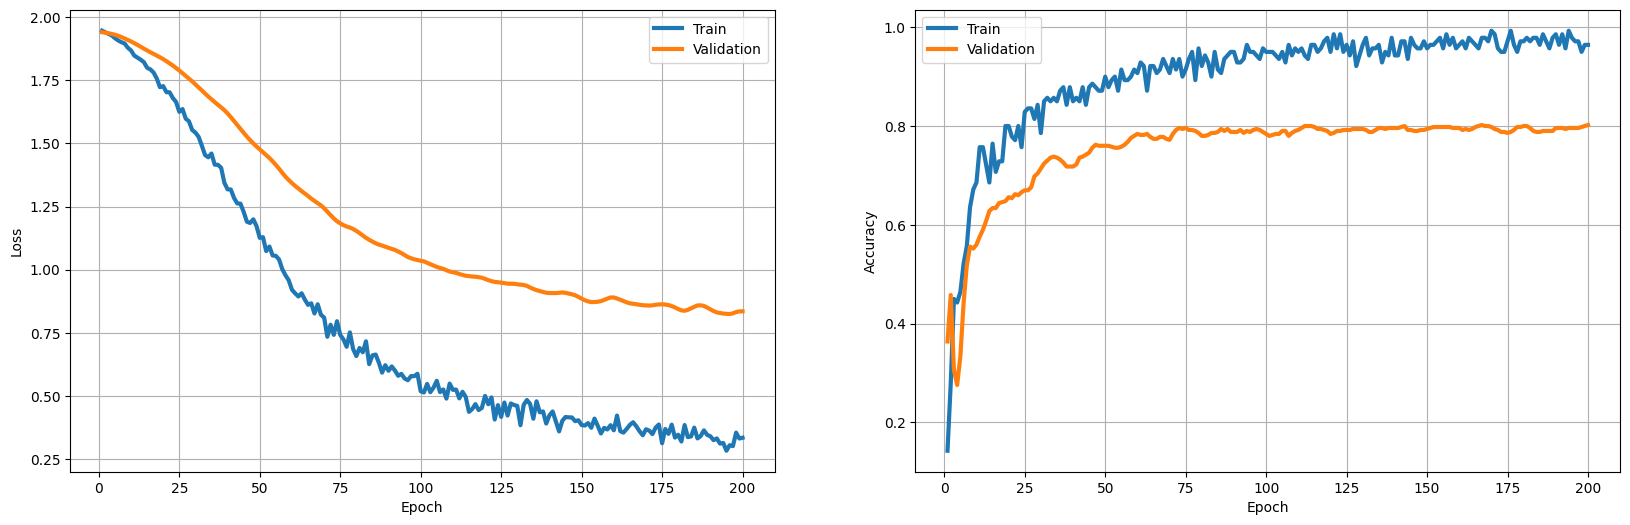

In [78]:
plot_results(n_epochs,train_losses,train_accs,val_losses,val_accs)

In [79]:
test_acc,_ = eval(model,data,data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8160


## Structural features

In [70]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx, from_networkx

!pip install networkx

In [71]:
def concatenate_features(data_x, *args):
  data_x_list = data_x.tolist()
  for i in range(len(data_x_list)):
    for arg in args:
      data_x_list[i].append(arg[i])

  return torch.tensor(data_x_list)

In [72]:
G = to_networkx(data)

cc = nx.closeness_centrality(G)
bc = nx.betweenness_centrality(G)
dc = nx.degree_centrality(G)
ec = nx.eigenvector_centrality(G)

new_x = concatenate_features(data.x,cc,bc,dc,ec)

In [73]:
from torch_geometric.data import Data

new_data = Data(x=new_x, edge_index=data.edge_index, y=data.y, train_mask=data.train_mask, val_mask=data.val_mask, test_mask=data.test_mask)
print(new_data)

Data(x=[2708, 1437], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


## GCN with centrality features

In [85]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
new_data = new_data.to(device)
new_model = GCN(new_data,hidden_channels=16)
new_model = new_model.to(device)
optimizer = torch.optim.Adam(new_model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
n_epochs = 200

train_losses, train_accs, val_losses, val_accs = model_training(n_epochs,new_model,new_data,optimizer,criterion)

Epoch: 001, Train Loss: 1.9466, Val Loss: 1.9411
Epoch: 002, Train Loss: 1.9404, Val Loss: 1.9390
Epoch: 003, Train Loss: 1.9336, Val Loss: 1.9331
Epoch: 004, Train Loss: 1.9243, Val Loss: 1.9264
Epoch: 005, Train Loss: 1.9133, Val Loss: 1.9227
Epoch: 006, Train Loss: 1.9052, Val Loss: 1.9191
Epoch: 007, Train Loss: 1.8985, Val Loss: 1.9148
Epoch: 008, Train Loss: 1.8834, Val Loss: 1.9090
Epoch: 009, Train Loss: 1.8714, Val Loss: 1.9021
Epoch: 010, Train Loss: 1.8587, Val Loss: 1.8943
Epoch: 011, Train Loss: 1.8477, Val Loss: 1.8857
Epoch: 012, Train Loss: 1.8347, Val Loss: 1.8766
Epoch: 013, Train Loss: 1.8216, Val Loss: 1.8670
Epoch: 014, Train Loss: 1.7993, Val Loss: 1.8574
Epoch: 015, Train Loss: 1.7870, Val Loss: 1.8477
Epoch: 016, Train Loss: 1.7795, Val Loss: 1.8379
Epoch: 017, Train Loss: 1.7445, Val Loss: 1.8280
Epoch: 018, Train Loss: 1.7463, Val Loss: 1.8182
Epoch: 019, Train Loss: 1.7235, Val Loss: 1.8086
Epoch: 020, Train Loss: 1.7014, Val Loss: 1.8000
Epoch: 021, Train Lo

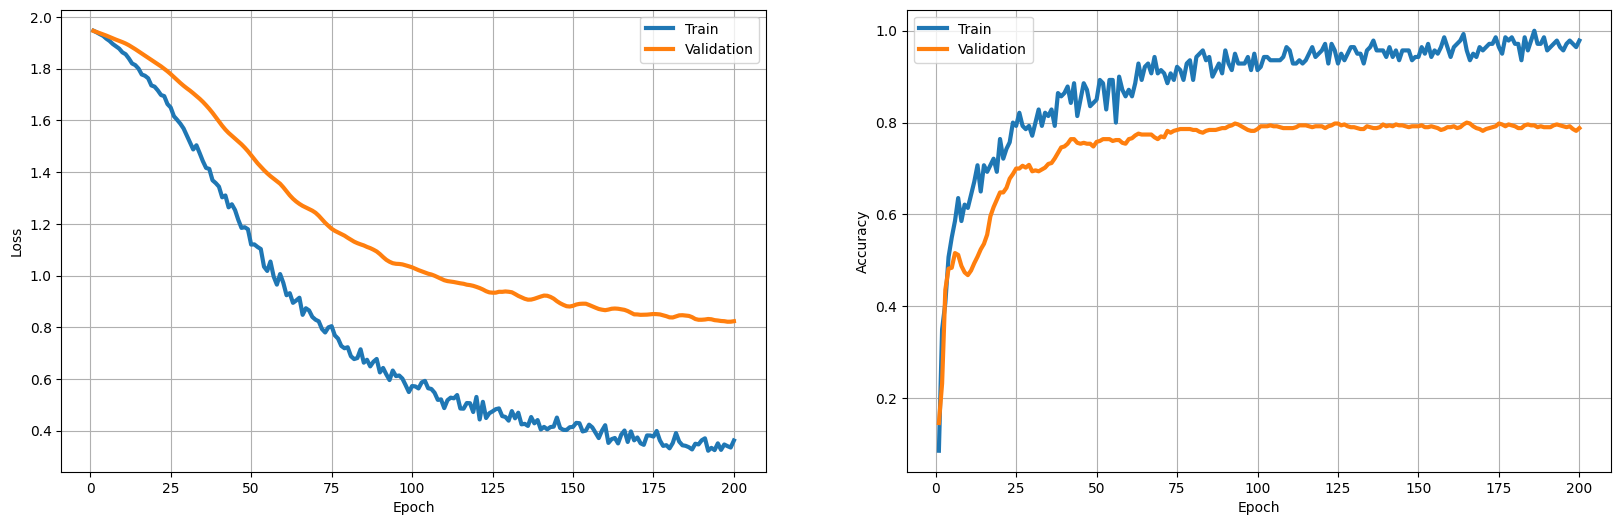

In [81]:
plot_results(n_epochs,train_losses,train_accs,val_losses,val_accs)

In [87]:
test_acc,_ = eval(new_model,new_data,new_data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8140


## Comparison

In [92]:
def run(n_runs,data):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  criterion = torch.nn.CrossEntropyLoss()
  n_epochs = 200
  data = data.to(device)
  test_accs = []

  for i in range(1,n_runs+1):
    print(f"\n RUN: {i}\n")

    model = GCN(data,hidden_channels=16)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    train_losses, train_accs, val_losses, val_accs = model_training(n_epochs,model,data,optimizer,criterion)
    test_acc, _  = eval(model,data,data.test_mask)
    test_accs.append(test_acc)

  return sum(test_accs)/len(test_accs)

In [93]:
avg_acc = run(10,data)
avg_acc_new = run(10,new_data)

print(f'Avg test acc original data: {avg_acc}')
print(f'Avg test acc new data:{avg_acc_new}')


 RUN: 1

Epoch: 001, Train Loss: 1.9465, Val Loss: 1.9431
Epoch: 002, Train Loss: 1.9420, Val Loss: 1.9416
Epoch: 003, Train Loss: 1.9364, Val Loss: 1.9383
Epoch: 004, Train Loss: 1.9312, Val Loss: 1.9344
Epoch: 005, Train Loss: 1.9218, Val Loss: 1.9306
Epoch: 006, Train Loss: 1.9143, Val Loss: 1.9262
Epoch: 007, Train Loss: 1.9069, Val Loss: 1.9212
Epoch: 008, Train Loss: 1.8961, Val Loss: 1.9158
Epoch: 009, Train Loss: 1.8894, Val Loss: 1.9108
Epoch: 010, Train Loss: 1.8720, Val Loss: 1.9052
Epoch: 011, Train Loss: 1.8708, Val Loss: 1.8994
Epoch: 012, Train Loss: 1.8575, Val Loss: 1.8931
Epoch: 013, Train Loss: 1.8390, Val Loss: 1.8869
Epoch: 014, Train Loss: 1.8294, Val Loss: 1.8806
Epoch: 015, Train Loss: 1.8124, Val Loss: 1.8746
Epoch: 016, Train Loss: 1.8039, Val Loss: 1.8687
Epoch: 017, Train Loss: 1.7839, Val Loss: 1.8625
Epoch: 018, Train Loss: 1.7764, Val Loss: 1.8559
Epoch: 019, Train Loss: 1.7583, Val Loss: 1.8481
Epoch: 020, Train Loss: 1.7420, Val Loss: 1.8402
Epoch: 021